# Whisper Model Baseline Evaluation

This notebook establishes baseline performance metrics for the Whisper-small model, which will serve as our reference for comparison with quantized versions.

## Metrics tracked:
- Word Error Rate (WER)
- Character Error Rate (CER)
- Inference time
- Memory usage
- Model size

In [ ]:
import sys
from pathlib import Path

# First make sure the project root is in the Python path
notebook_dir = Path().absolute()
project_root = notebook_dir.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from whisper_quantization_pkg import config, data, utils  # our utilities

# Set up configuration
project_config = config.ProjectConfig()  # This will create all necessary directories

# Set up plotting style
sns.set_theme()
plt.style.use("seaborn-v0_8")
%matplotlib inline

# Set up device
device = utils.setup_device()

# Print current working directory and project root to verify
print(f"Current directory: {notebook_dir}")
print(f"Project root: {project_root}")
print(f"Models will be saved in: {project_config.dirs['models']}")

Using MPS backend
Current directory: /Users/julian/Documents/ITU/whisper_quantization/notebooks
Project root: /Users/julian/Documents/ITU/whisper_quantization
Models will be saved in: /Users/julian/Documents/ITU/whisper_quantization/models


## Load Model and Initialize Profiler

In [2]:
# Initialize model and profiler
print("Loading Whisper model and processor...")
model_id = "openai/whisper-small"
profiler = utils.ModelProfiler("whisper-small-baseline")
model = WhisperForConditionalGeneration.from_pretrained(
    model_id,
    forced_decoder_ids=None,  # Allow model to auto-detect language
    generation_config=None,  # Use default generation config
)
processor = WhisperProcessor.from_pretrained(
    model_id,
    language="en",  # Specify English as target language
    task="transcribe",  # Specify transcription task
)

# Print model size
model_size = profiler.measure_model_size(model)
print(f"Model size: {model_size:.2f} MB")

Loading Whisper model and processor...
Model size: 922.15 MB


In [3]:
# Get detailed size analysis
size_details = profiler.get_detailed_model_size(model)
profiler.print_size_analysis()

Model Size Analysis for whisper-small-baseline
--------------------------------------------------
Total Model Size: 922.15 MB
Parameter Size: 922.15 MB
Buffer Size: 0.00 MB
Total Parameters: 241,734,912

Layer-by-Layer Breakdown:
--------------------------------------------------
model.decoder.embed_tokens.weight:
  Size: 151.95 MB
  Parameters: 39,832,320
------------------------------
model.encoder.layers.0.fc1.weight:
  Size: 9.00 MB
  Parameters: 2,359,296
------------------------------
model.encoder.layers.0.fc2.weight:
  Size: 9.00 MB
  Parameters: 2,359,296
------------------------------
model.encoder.layers.1.fc1.weight:
  Size: 9.00 MB
  Parameters: 2,359,296
------------------------------
model.encoder.layers.1.fc2.weight:
  Size: 9.00 MB
  Parameters: 2,359,296
------------------------------
model.encoder.layers.2.fc1.weight:
  Size: 9.00 MB
  Parameters: 2,359,296
------------------------------
model.encoder.layers.2.fc2.weight:
  Size: 9.00 MB
  Parameters: 2,359,296
-----

## Load Dataset

In [4]:
# For development
test_dataset = data.load_librispeech(num_samples=100)

# Later, for final evaluation
# full_test_dataset = load_librispeech()

Loaded 100 test samples


In [5]:
data.examine_dataset(test_dataset)

Dataset Overview:
--------------------------------------------------
Number of samples: 100
Features available: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id']

Audio Characteristics:
--------------------------------------------------
Sampling rate: 16000 Hz
Average duration: 6.71 seconds
Min duration: 1.81 seconds
Max duration: 23.32 seconds

Text Characteristics:
--------------------------------------------------
Average words per sample: 18.70
Min words: 3
Max words: 64

Number of unique speakers: 2

Example Sample:
--------------------------------------------------
Text: CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
Speaker ID: 6930
Duration: 3.50 seconds


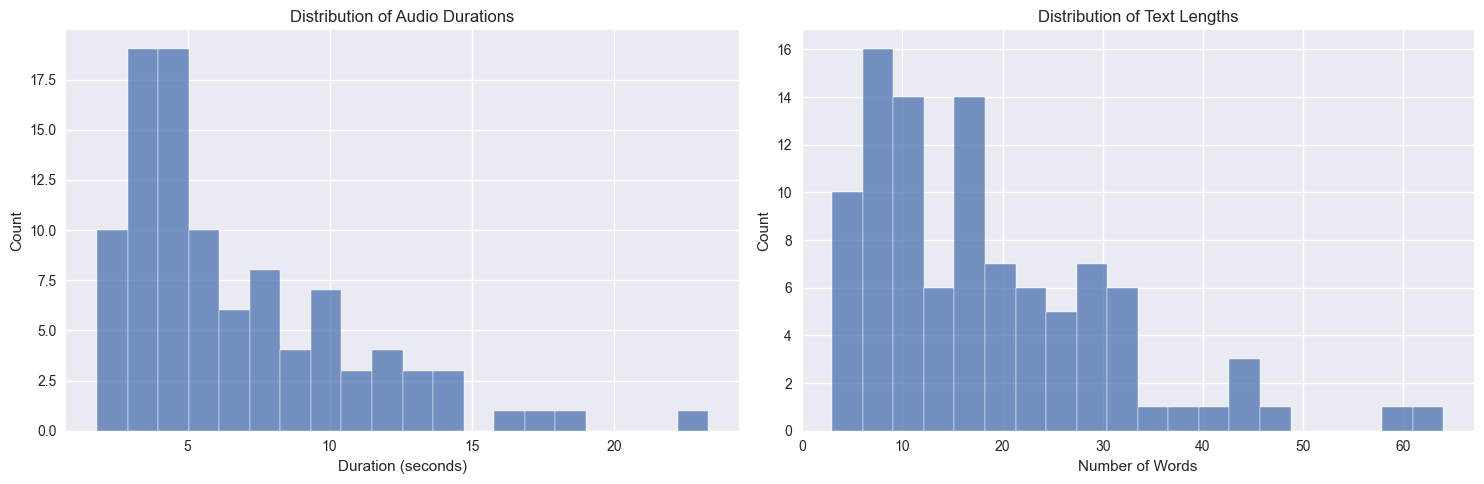

In [6]:
data.plot_dataset_distributions(test_dataset)

Analyzing Sample 92
Audio Characteristics:
--------------------------------------------------
Sampling rate: 16000 Hz
Audio shape: (78400,)
Duration: 4.90 seconds

Audio Statistics:
Mean amplitude: -0.000533
Max amplitude: 0.545471
RMS energy: 0.065586

MFCC shape: (13, 154)


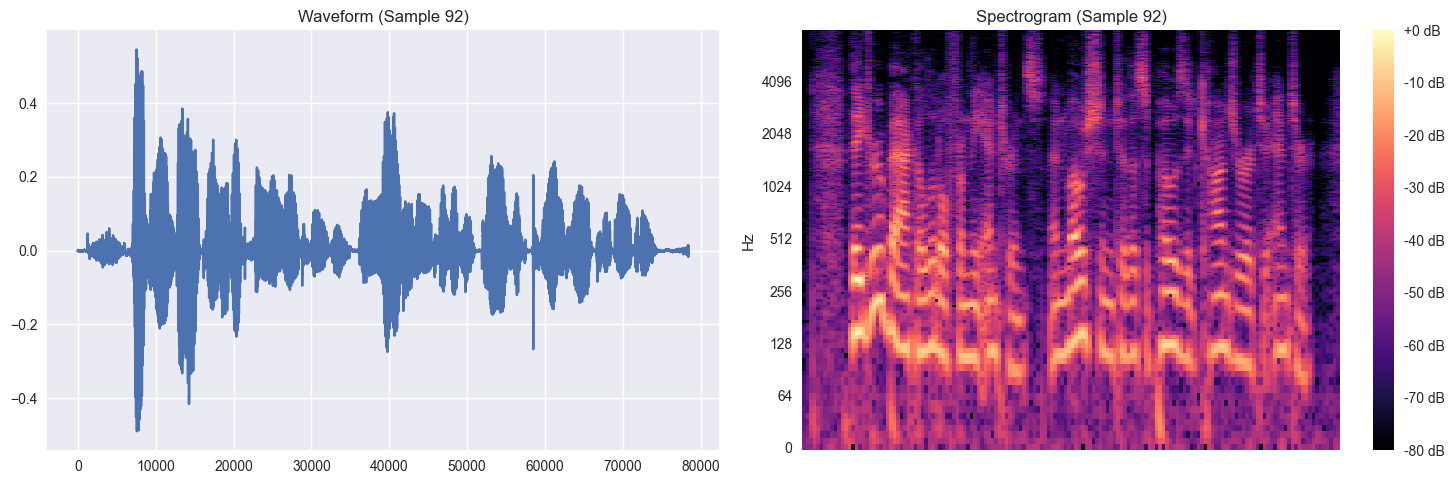

In [7]:
data.analyze_audio_characteristics(test_dataset, 92)

In [8]:
data.play_sample(test_dataset, 92)  # Play first sample

Text: THEY DREW BACK A LITTLE FROM THE ENTRANCE AND MOTIONED TO THE SUPPOSED CONJURER TO ENTER
Duration: 4.90 seconds
Speaker ID: 1320


## Run Evaluation

In [9]:
# Initialize evaluator and run evaluation
evaluator = utils.WhisperEvaluator(model, processor, device, profiler)
results_df = evaluator.evaluate_dataset(test_dataset)

# Save model and results
evaluator.save_model("whisper-small-baseline")  # No need for full path
results_df.to_csv(project_config.dirs["results"] / "baseline_results.csv", index=False)
profiler.save_metrics("baseline_metrics.json")  # Just filename, path handled internally

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/julian/Documents/ITU/whisper_quantization/venv/lib/python3.11/site-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Model and processor saved to '/Users/julian/Documents/ITU/whisper_quantization/models/whisper-small-baseline'
Metrics saved to /Users/julian/Documents/ITU/whisper_quantization/results/baseline_metrics.json


## Analyze Results

In [10]:
# Calculate metrics including model size
metrics = utils.TranscriptionMetrics.calculate_summary_metrics(results_df, model_size=model_size)

# Print formatted summary
utils.TranscriptionMetrics.print_summary(metrics)

# Save summary metrics
summary_path = project_config.dirs["results"] / "baseline_summary.csv"
utils.TranscriptionMetrics.save_summary(metrics, summary_path)


Summary Metrics:
--------------------------------------------------

Error Rates:
  avg_wer....................... 0.0473
  median_wer.................... 0.0000
  std_wer....................... 0.0788
  avg_cer....................... 0.0174
  median_cer.................... 0.0000
  std_cer....................... 0.0393

Performance:
  avg_inference_time............ 0.5280
  avg_memory_used............... 2.1791
  model_size_mb................. 922.1455
Summary metrics saved to /Users/julian/Documents/ITU/whisper_quantization/results/baseline_summary.csv


## Visualize Results


Generating plots...


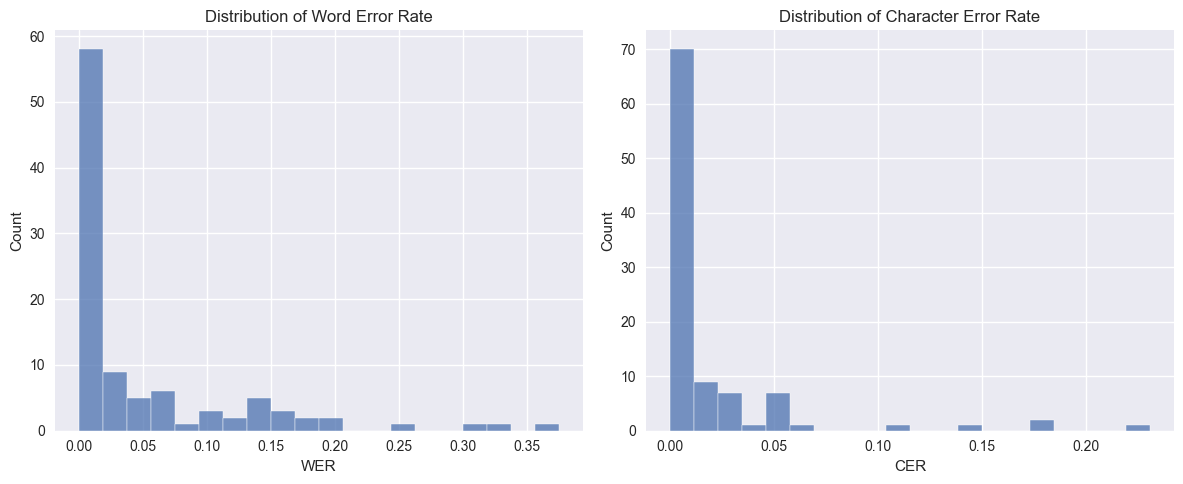

Plot saved to /Users/julian/Documents/ITU/whisper_quantization/results/plots/error_distributions.png


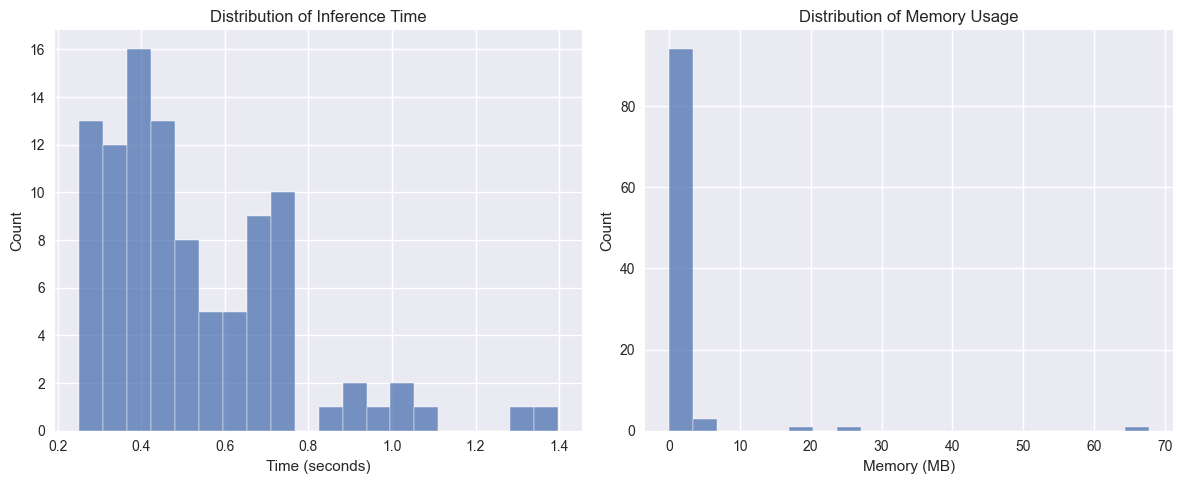

Plot saved to /Users/julian/Documents/ITU/whisper_quantization/results/plots/performance_metrics.png


In [11]:
# STEP 6: Plot distributions
print("\nGenerating plots...")
viz = utils.VisualizationUtils()
viz.plot_error_distributions(results_df, "error_distributions.png")  # Just filename
viz.plot_performance_metrics(results_df, "performance_metrics.png")  # Just filename

In [12]:
# Display sample comparisons
print("\nSample Comparisons:")
utils.TranscriptionMetrics.print_sample_comparisons(results_df, n_samples=20)


Sample Comparisons:

Sample Transcriptions:

Reference:
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS

Hypothesis:
 Concord returned to its place amidst the tents.
WER: 0.0000, CER: 0.0000
--------------------------------------------------------------------------------

Reference:
THE ENGLISH FORWARDED TO THE FRENCH BASKETS OF FLOWERS OF WHICH THEY HAD MADE A PLENTIFUL PROVISION TO GREET THE ARRIVAL OF THE YOUNG PRINCESS THE FRENCH IN RETURN INVITED THE ENGLISH TO A SUPPER WHICH WAS TO BE GIVEN THE NEXT DAY

Hypothesis:
 The English voted to the French baskets of flowers of which they had made a plentiful provision to greet the arrival of the young princess. The French, in return, invited the English to a supper, which was to be given the next day.
WER: 0.0233, CER: 0.0261
--------------------------------------------------------------------------------

Reference:
CONGRATULATIONS WERE POURED IN UPON THE PRINCESS EVERYWHERE DURING HER JOURNEY

Hypothesis:
 Congratulations were poured 